In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv
/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx
/kaggle/input/siyam-rupali-text/Siyamrupali.ttf


# **Updating Libraries**

In [2]:
#!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

     |████████████████████████████████| 103 kB 748 kB/s 
     |████████████████████████████████| 242 kB 544 kB/s 


# **Importing Libraries**

In [3]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
from collections import Counter

from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# **Loading Dataset**

In [4]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [5]:
display(df_train)
display(df_test)

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...
...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...


,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...
...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...


# **TrainSet Description**

In [6]:
print("First rows of TrainSet....")
df_train.head()

First rows of TrainSet....


,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...


In [7]:
print("Description of TrainSet...")
df_train.describe()

Description of TrainSet...


,category,text,cleanText
count,98883,98883,98883
unique,7,98425,97926
top,sports,"প্রিয় শিক্ষার্থী বন্ধুরা, তোমাদের হাতে আঁকা র...",প্রিয় শিক্ষার্থী বন্ধুরা তোমাদের ...
freq,15672,25,25


In [8]:
print("Dataframe Information on TrainSet...")
df_train.info()

Dataframe Information on TrainSet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [9]:
print("Categories of Trainset:")
print(df_train.category.unique())
category_list=df_train.category.unique()

Categories of Trainset:
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


# **Testset Description**

In [10]:
print("First rows of TrainSet....")
df_test.head()

First rows of TrainSet....


,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...


In [11]:
print("Description of TrainSe....")
df_test.describe()

Description of TrainSe....


,category,text,cleanText
count,98884,98884,98884
unique,7,98384,97880
top,sports,"প্রিয় শিক্ষার্থী বন্ধুরা, তোমাদের হাতে আঁকা র...",প্রিয় শিক্ষার্থী বন্ধুরা তোমাদের ...
freq,15883,30,31


In [12]:
print("Information of TrainSet dataframe....")
df_test.info()

Information of TrainSet dataframe....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [13]:
print("Categories:")
print(df_train.category.unique())
category_list=df_train.category.unique()

Categories:
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


# **Removing Null Values**

In [14]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# **Removing Low Length Data**

In [15]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>5]
df_test= df_test.loc[df_test['count']>5]

# **Preprocessing/Cleaning**
Though the dataset is said to have been cleaned,but i have applied it anyway to remove Unecessary charachters,Emojis,Punctuations with the help of Regex.

In [16]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [17]:
#df_train['cleanText'] = df_train.cleanText.apply(lambda x: preprocessing(str(x)))
#df_test['cleanText'] = df_test.cleanText.apply(lambda x: preprocessing(str(x)))

# **Stopwords Removal**

This is a stopwords list containing about 700+ bangla stopwords. I have manually collected this stopwords.

In [18]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [19]:
display(data1)

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [20]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [21]:
#df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))
#df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [22]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [23]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

I have used a Bangla Stemmer for the dataset. But through experimentation,i have seen than stemming doesn't have that much effect on our accuracy measures. So i have commented out the corresponding code.

# **Category Wise Data Distribution**

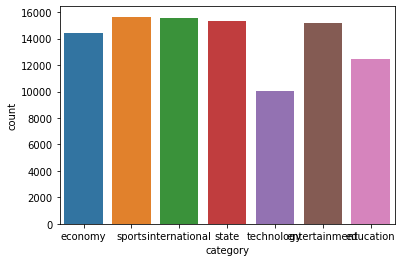

In [24]:
sns.countplot(df_train['category']);

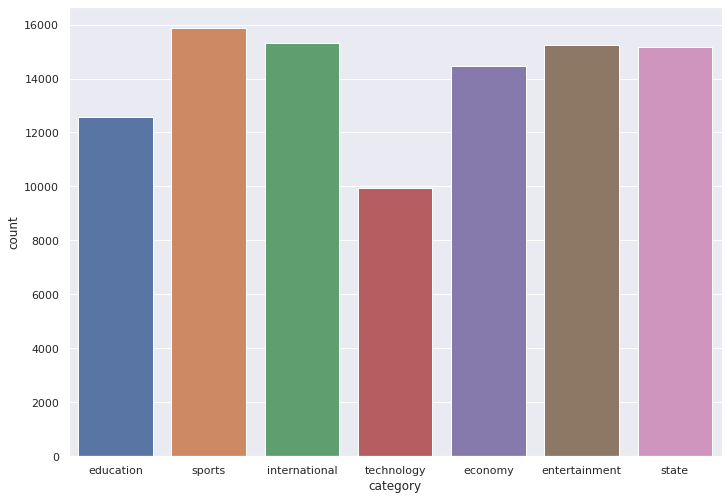

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df_test['category']);

In both train set and test set,the data have no imbalance problem. We can see that every class have sufficient amount of data.

# **Count of Texts in Each Category**

In [26]:
print("IN TRAIN SET...")
temp1 = df_train.groupby('category').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp1.style.background_gradient(cmap='Purples')

IN TRAIN SET...


,category,cleanText
4,sports,15656
3,international,15540
5,state,15362
2,entertainment,15183
0,economy,14426
1,education,12453
6,technology,10005


In [27]:
print("In Test Set...")
temp2 = df_test.groupby('category').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp2.style.background_gradient(cmap='Purples')

In Test Set...


,category,cleanText
4,sports,15867
3,international,15313
2,entertainment,15242
5,state,15183
0,economy,14480
1,education,12582
6,technology,9935


# **Funnel Chart of Data Distribution**

In [28]:
from plotly import graph_objs as go
print("On Train Set....")
fig = go.Figure(go.Funnelarea(
    text =temp1.category,
    values = temp1.cleanText,
    title = {"position": "top center", "text": "Funnel-Chart of Category Distribution on Train Set"}
    ))
fig.show()

On Train Set....


In [29]:
print("On Test Set...")
fig = go.Figure(go.Funnelarea(
    text =temp2.category,
    values = temp2.cleanText,
    title = {"position": "top center", "text": "Funnel-Chart of Category Distribution on Test Set"}
    ))
fig.show()

On Test Set...


# **Count Based Top Words in Each Category on Train Set**

In [30]:
category_list=category_list.tolist()
for i in category_list:
    temp=df_train.loc[df_train['category'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In '+ str(i)+" Category")
    display(temp)
    

,Common_words,count
0,টাকা,30065
1,কোটি,25990
2,হাজার,23905
3,বাংলাদেশ,18324
4,শতাংশ,17587
5,লাখ,16336
6,ব্যাংক,14530
7,ব্যাংকের,14399
8,দাম,11825
9,বেশি,11087


,Common_words,count
0,প্রথম,15970
1,দলের,14527
2,শেষ,14272
3,রান,13770
4,ম্যাচ,13116
5,বাংলাদেশ,12877
6,বিপক্ষে,12667
7,দুই,12627
8,ম্যাচে,12342
9,বাংলাদেশের,10494


,Common_words,count
0,গতকাল,10137
1,প্রেসিডেন্ট,10051
2,কথা,9469
3,দুই,7966
4,ভারতের,7858
5,বছর,7827
6,সময়,7812
7,মার্কিন,7317
8,হিসেবে,7245
9,বিরুদ্ধে,7196


,Common_words,count
0,গতকাল,13143
1,পুলিশ,11561
2,প্রথম,9498
3,জানান,8401
4,দুই,8372
5,টাকা,8200
6,কথা,8177
7,সময়,8048
8,জেলা,7942
9,হাজার,7651


,Common_words,count
0,নতুন,8822
1,তথ্য,7509
2,কাজ,6665
3,তৈরি,5992
4,বেশি,5752
5,ফেসবুক,5266
6,হিসেবে,5258
7,বিভিন্ন,5199
8,টাকা,5173
9,প্রযুক্তি,5046


,Common_words,count
0,ছবির,14623
1,ছবি,13067
2,কথা,12019
3,কাজ,11972
4,গান,11359
5,অভিনয়,10525
6,প্রথম,10290
7,শুরু,9163
8,নতুন,8852
9,ছবিতে,8783


,Common_words,count
0,উত্তর,19379
1,বিশ্ববিদ্যালয়ের,12158
2,কোনটি,11735
3,ঢাকা,9552
4,প্রশ্ন,7802
5,শিক্ষক,7302
6,অধ্যাপক,6921
7,কলেজ,6801
8,শিক্ষার্থী,6687
9,বিশ্ববিদ্যালয়,6609


# **Top 20 Words in TrainSet Based on Count**

In [31]:

df_train['temp_list'] = df_train['cleanText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,প্রথম,55959
1,কথা,53579
2,টাকা,51486
3,হাজার,50108
4,বাংলাদেশ,49988
5,সময়,47409
6,দুই,45712
7,বছর,44889
8,শুরু,44323
9,নতুন,44189


# **Top 20 Words in TestSet Based on Count**

In [32]:

df_test['temp_list'] = df_test['cleanText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_test['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,প্রথম,54665
1,কথা,52686
2,টাকা,50839
3,বাংলাদেশ,50340
4,হাজার,49901
5,সময়,47163
6,দুই,45368
7,বছর,44635
8,শুরু,44163
9,নতুন,43594


# **Histogram Analysis Based on Text Length**

In [33]:
fig = go.Figure(layout=dict(title=dict(text="Text Length Histogram of Trainset")))
fig.add_trace(go.Histogram(x=df_train['count']))
fig.show()

In [34]:
fig = go.Figure(layout=dict(title=dict(text="Text Length Histogram of Testset")))
fig.add_trace(go.Histogram(x=df_test['count']))
fig.show()

From the histogram,we can say that abobut 97% of the text lenght are between 1-600. This information is valuable for model creation and text lenght selection.

# **N gram Analysis**

In [35]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [36]:
# function to create top 20 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["cleanText"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top20 = esBigram_wordlist.most_common(20)
    top20 = dict(top20)
    df_ngrams = pd.DataFrame(sorted(top20.items(), key=lambda x: x[1])[::-1])
    df_ngrams.columns = ['Ngram','count']
    return df_ngrams


# function to visualize the top 20 n-grams
def show(train):
    display(train.head(20))

# **Top 20 Unigram Count Based On Category**

In [37]:
for i in category_list:
    temp=df_train.loc[df_train['category'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_unigrams = get_ngrams(temp,1)
    print("\t\t\t====== Unigrams of "+str(i)+"======")   
    show(train_unigrams)

			====== Unigrams of economy======


,Ngram,count
0,"(টাকা,)",30065
1,"(কোটি,)",25990
2,"(হাজার,)",23905
3,"(বাংলাদেশ,)",18324
4,"(শতাংশ,)",17587
5,"(লাখ,)",16336
6,"(ব্যাংক,)",14530
7,"(ব্যাংকের,)",14399
8,"(দাম,)",11825
9,"(বেশি,)",11087


			====== Unigrams of sports======


,Ngram,count
0,"(প্রথম,)",15970
1,"(দলের,)",14527
2,"(শেষ,)",14272
3,"(রান,)",13770
4,"(ম্যাচ,)",13116
5,"(বাংলাদেশ,)",12878
6,"(বিপক্ষে,)",12667
7,"(দুই,)",12627
8,"(ম্যাচে,)",12342
9,"(বাংলাদেশের,)",10494


			====== Unigrams of international======


,Ngram,count
0,"(গতকাল,)",10137
1,"(প্রেসিডেন্ট,)",10051
2,"(কথা,)",9469
3,"(দুই,)",7966
4,"(ভারতের,)",7858
5,"(বছর,)",7827
6,"(সময়,)",7812
7,"(মার্কিন,)",7317
8,"(হিসেবে,)",7245
9,"(বিরুদ্ধে,)",7196


			====== Unigrams of state======


,Ngram,count
0,"(গতকাল,)",13143
1,"(পুলিশ,)",11561
2,"(প্রথম,)",9498
3,"(জানান,)",8401
4,"(দুই,)",8372
5,"(টাকা,)",8200
6,"(কথা,)",8177
7,"(সময়,)",8048
8,"(জেলা,)",7942
9,"(হাজার,)",7651


			====== Unigrams of technology======


,Ngram,count
0,"(নতুন,)",8822
1,"(তথ্য,)",7509
2,"(কাজ,)",6665
3,"(তৈরি,)",5992
4,"(বেশি,)",5752
5,"(ফেসবুক,)",5266
6,"(হিসেবে,)",5259
7,"(বিভিন্ন,)",5199
8,"(টাকা,)",5173
9,"(প্রযুক্তি,)",5046


			====== Unigrams of entertainment======


,Ngram,count
0,"(ছবির,)",14623
1,"(ছবি,)",13067
2,"(কথা,)",12019
3,"(কাজ,)",11972
4,"(গান,)",11359
5,"(অভিনয়,)",10525
6,"(প্রথম,)",10290
7,"(শুরু,)",9163
8,"(নতুন,)",8852
9,"(ছবিতে,)",8783


			====== Unigrams of education======


,Ngram,count
0,"(উত্তর,)",19392
1,"(বিশ্ববিদ্যালয়ের,)",12158
2,"(কোনটি,)",11735
3,"(ঢাকা,)",9558
4,"(প্রশ্ন,)",7859
5,"(শিক্ষক,)",7303
6,"(অধ্যাপক,)",6921
7,"(কলেজ,)",6808
8,"(শিক্ষার্থী,)",6687
9,"(বিশ্ববিদ্যালয়,)",6609


# **Top 20 Bigram Count Based On Category**

In [38]:
for i in category_list:
    temp=df_train.loc[df_train['category'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_bigrams = get_ngrams(temp,2)
    print("\t\t\t====== Bigrams of "+str(i)+" ======")   
    show(train_bigrams)

			====== Bigrams of economy ======


,Ngram,count
0,"(কোটি, টাকা)",9864
1,"(হাজার, কোটি)",8545
2,"(কোটি, লাখ)",7413
3,"(দশমিক, শতাংশ)",5366
4,"(লাখ, টাকা)",4608
5,"(লাখ, হাজার)",4058
6,"(বাংলাদেশ, ব্যাংকের)",3811
7,"(হাজার, টাকা)",3771
8,"(কোটি, টাকার)",3170
9,"(ব্যবস্থাপনা, পরিচালক)",2844


			====== Bigrams of sports ======


,Ngram,count
0,"(জাতীয়, দলের)",1617
1,"(দক্ষিণ, আফ্রিকার)",1610
2,"(সবচেয়ে, বেশি)",1569
3,"(দক্ষিণ, আফ্রিকা)",1485
4,"(বছর, বয়সী)",1394
5,"(বাংলাদেশ, দলের)",1331
6,"(ওয়েস্ট, ইন্ডিজ)",1283
7,"(ওয়েস্ট, ইন্ডিজের)",1107
8,"(সংবাদ, সম্মেলনে)",1101
9,"(রানে, উইকেট)",1012


			====== Bigrams of international ======


,Ngram,count
0,"(মার্কিন, প্রেসিডেন্ট)",1428
1,"(বার্তা, সংস্থা)",1425
2,"(বছর, বয়সী)",1394
3,"(প্রধানমন্ত্রী, নরেন্দ্র)",977
4,"(গতকাল, মঙ্গলবার)",963
5,"(দুই, দেশের)",963
6,"(গতকাল, বুধবার)",951
7,"(গতকাল, বৃহস্পতিবার)",943
8,"(উত্তর, কোরিয়ার)",929
9,"(ঘটনা, ঘটে)",916


			====== Bigrams of state ======


,Ngram,count
0,"(আওয়ামী, লীগের)",4527
1,"(প্রথম, আলোকে)",4273
2,"(সাধারণ, সম্পাদক)",3663
3,"(হাজার, টাকা)",2342
4,"(মেডিকেল, কলেজ)",2064
5,"(ভারপ্রাপ্ত, কর্মকর্তা)",1984
6,"(থানার, ভারপ্রাপ্ত)",1930
7,"(কর্মকর্তা, ওসি)",1792
8,"(আওয়ামী, লীগ)",1518
9,"(লাখ, টাকা)",1348


			====== Bigrams of technology ======


,Ngram,count
0,"(প্রধান, নির্বাহী)",1585
1,"(হাজার, টাকা)",1325
2,"(আইটি, ডেস্ক)",899
3,"(মোবাইল, ফোন)",879
4,"(মার্কিন, ডলার)",734
5,"(অপারেটিং, সিস্টেম)",725
6,"(কোটি, লাখ)",723
7,"(ব্যবস্থাপনা, পরিচালক)",704
8,"(র, ্যাম)",629
9,"(নির্বাহী, কর্মকর্তা)",621


			====== Bigrams of entertainment ======


,Ngram,count
0,"(চরিত্রে, অভিনয়)",1809
1,"(শাকিব, খান)",1273
2,"(ছবিতে, অভিনয়)",1260
3,"(ছবির, শুটিং)",1091
4,"(সালমান, খান)",870
5,"(প্রথম, আলোকে)",863
6,"(মুক্তি, পাবে)",840
7,"(শুটিং, শুরু)",826
8,"(প্রথম, আলোর)",802
9,"(বছর, বয়সী)",797


			====== Bigrams of education ======


,Ngram,count
0,"(কোনটি, সঠিক)",3841
1,"(নিচের, কোনটি)",2713
2,"(অংশ, ছাপা)",2247
3,"(প্রশ্নের, উত্তর)",2231
4,"(কলেজ, ঢাকা)",2193
5,"(সাধারণ, সম্পাদক)",1676
6,"(ঢাকা, বিশ্ববিদ্যালয়ের)",1625
7,"(অ্যান্ড, কলেজ)",1604
8,"(বাকি, অংশ)",1561
9,"(স্কুল, অ্যান্ড)",1409


# **Top 20 Trigram Count Based On Category**

In [39]:
for i in category_list:
    temp=df_train.loc[df_train['category'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_trigrams = get_ngrams(temp,3)
    print("\t\t\t====== Trigrams of "+str(i)+" ======")   
    show(train_trigrams)

			====== Trigrams of economy ======


,Ngram,count
0,"(হাজার, কোটি, টাকা)",4827
1,"(কোটি, লাখ, টাকা)",3093
2,"(কোটি, লাখ, ডলার)",1213
3,"(লাখ, হাজার, কোটি)",1147
4,"(হাজার, কোটি, টাকার)",1099
5,"(আবুল, মাল, আবদুল)",978
6,"(অর্থমন্ত্রী, আবুল, মাল)",938
7,"(হাজার, কোটি, লাখ)",878
8,"(মাল, আবদুল, মুহিত)",811
9,"(কমেছে, টির, অপরিবর্তিত)",785


			====== Trigrams of sports ======


,Ngram,count
0,"(মাশরাফি, বিন, মুর্তজা)",472
1,"(দক্ষিণ, আফ্রিকার, বিপক্ষে)",425
2,"(ওয়েস্ট, ইন্ডিজের, বিপক্ষে)",382
3,"(ম্যান, দ্য, ম্যাচ)",339
4,"(মাশরাফি, বিন, মুর্তজার)",244
5,"(মেহেদী, হাসান, মিরাজ)",205
6,"(প্রথম, শ্রেণির, ক্রিকেটে)",205
7,"(জয়ী, ম্যান, দ্য)",170
8,"(রানে, উইকেট, হারিয়ে)",168
9,"(মিরপুর, শেরেবাংলা, স্টেডিয়ামে)",156


			====== Trigrams of international ======


,Ngram,count
0,"(প্রেসিডেন্ট, বারাক, ওবামা)",536
1,"(মার্কিন, প্রেসিডেন্ট, বারাক)",489
2,"(বিবিসি, অনলাইনের, প্রতিবেদনে)",417
3,"(প্রধানমন্ত্রী, নরেন্দ্র, মোদি)",414
4,"(ভারতের, প্রধানমন্ত্রী, নরেন্দ্র)",401
5,"(প্রেসিডেন্ট, ডোনাল্ড, ট্রাম্প)",398
6,"(বার্তা, সংস্থা, এএফপির)",383
7,"(ইসলামিক, স্টেটের, আইএস)",372
8,"(মার্কিন, প্রেসিডেন্ট, ডোনাল্ড)",320
9,"(ইসলামিক, স্টেট, আইএস)",295


			====== Trigrams of state ======


,Ngram,count
0,"(থানার, ভারপ্রাপ্ত, কর্মকর্তা)",1859
1,"(ভারপ্রাপ্ত, কর্মকর্তা, ওসি)",1789
2,"(মেডিকেল, কলেজ, হাসপাতালে)",1188
3,"(ঢাকা, মেডিকেল, কলেজ)",778
4,"(উপজেলা, নির্বাহী, কর্মকর্তা)",709
5,"(প্রধানমন্ত্রী, শেখ, হাসিনা)",658
6,"(লীগের, সাধারণ, সম্পাদক)",611
7,"(উপজেলা, আওয়ামী, লীগের)",577
8,"(জেলা, আওয়ামী, লীগের)",529
9,"(আওয়ামী, লীগের, সভাপতি)",518


			====== Trigrams of technology ======


,Ngram,count
0,"(প্রধান, নির্বাহী, কর্মকর্তা)",558
1,"(দাম, হাজার, টাকা)",484
2,"(তথ্য, যোগাযোগ, প্রযুক্তি)",403
3,"(প্রতিমন্ত্রী, জুনাইদ, আহমেদ)",307
4,"(জিবি, র, ্যাম)",257
5,"(জুনাইদ, আহমেদ, পলক)",212
6,"(বঙ্গবন্ধু, আন্তর্জাতিক, সম্মেলন)",208
7,"(কোটি, মার্কিন, ডলার)",190
8,"(আন্তর্জাতিক, সম্মেলন, কেন্দ্রে)",189
9,"(র, ্যাম, জিবি)",171


			====== Trigrams of entertainment ======


,Ngram,count
0,"(জাতীয়, চলচ্চিত্র, পুরস্কার)",344
1,"(ছবির, শুটিং, শুরু)",260
2,"(শাকিব, খান, অপু)",259
3,"(টিভি, গাজী, টিভি)",258
4,"(বাংলাদেশ, শিল্পকলা, একাডেমির)",250
5,"(সাইফ, আলী, খান)",229
6,"(খান, অপু, বিশ্বাস)",225
7,"(সংস্কৃতিমন্ত্রী, আসাদুজ্জামান, নূর)",222
8,"(মেরিল, প্রথম, আলো)",216
9,"(শিল্পকলা, একাডেমির, জাতীয়)",214


			====== Trigrams of education ======


,Ngram,count
0,"(নিচের, কোনটি, সঠিক)",1673
1,"(বাকি, অংশ, ছাপা)",1493
2,"(স্কুল, অ্যান্ড, কলেজ)",1260
3,"(প্রশ্নের, উত্তর, দাও)",1026
4,"(অ্যান্ড, কলেজ, ঢাকা)",685
5,"(অংশ, ছাপা, আগামীকাল)",658
6,"(পাবলিক, কলেজ, ঢাকা)",618
7,"(পূর্বে, প্রকাশিত, অংশের)",607
8,"(পরবর্তী, অংশ, ছাপা)",590
9,"(বঙ্গবন্ধু, শেখ, মুজিবুর)",544


# **Word Cloud Based On Category**

In [40]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

# Function for generating word clouds
def generate_wordcloud(data,title):
  data = [tuple(x) for x in data.values]
  wc = WordCloud(font_path="/kaggle/input/siyam-rupali-text/Siyamrupali.ttf",width=1080, height=720, max_words=150,colormap="Dark2").generate_from_frequencies(dict(data))
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap("Word Cloud of "+title,60)),fontsize=13)
  plt.show()

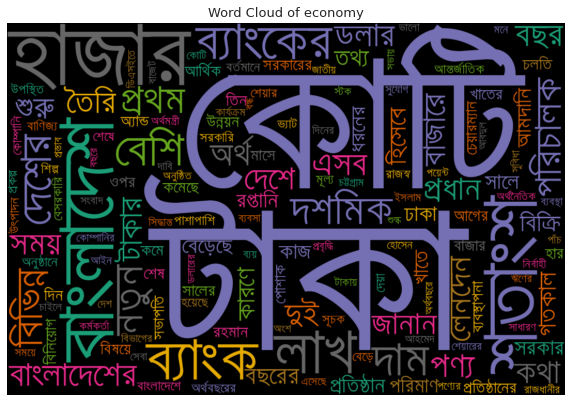

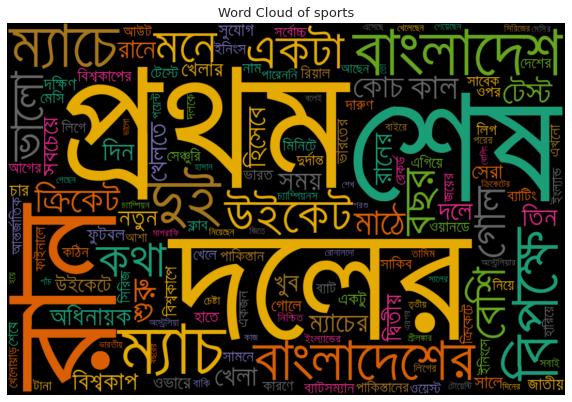

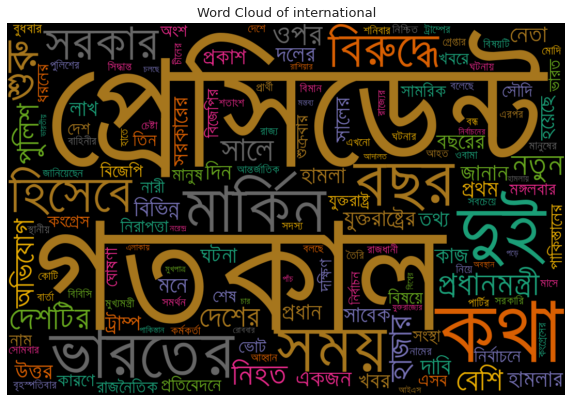

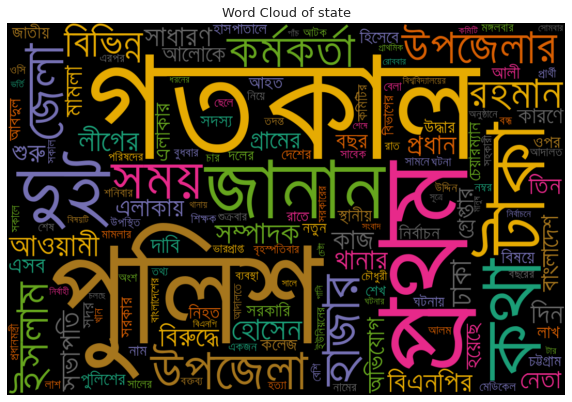

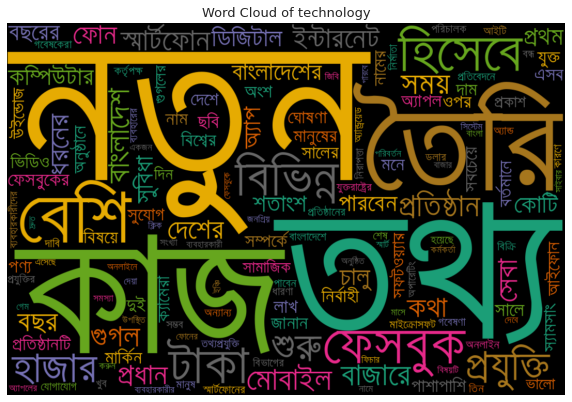

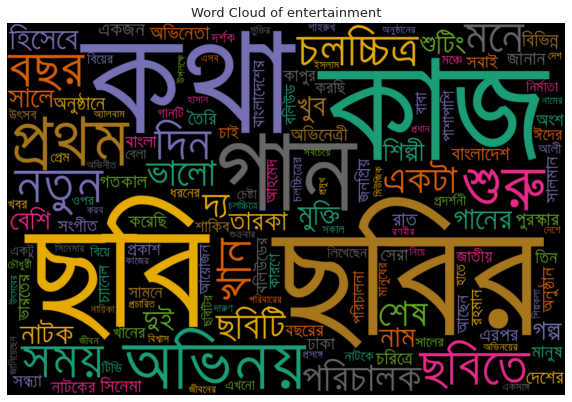

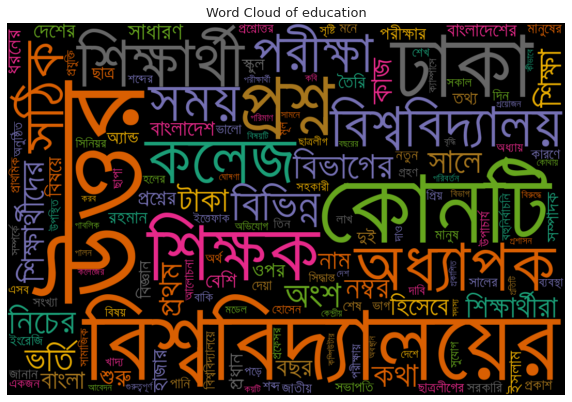

In [41]:

for i in category_list:
    temp=df_train.loc[df_train['category'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(500000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))
    

# **Conclusion Of EDA on banglaMCT7 Dataset**
* **Both TrainSet and TrainSet are similar in size.**
* **TraintSet and TestSet top word counts are similar,so we can say that TrainSet and TestSet are originated from same distribution of Data.**
* **The dataset don't have any data imbalance problem,every category have sufficient amount of data.**
* **Histogram analaysis shows that most of the text are of lenght 1-600.**
* **Category wise Ngram shows that the category wised created ngrams are relavent to that category.**
* **Category wise Word Cloud also shows result relavent to the category**